Nelder Mead

Final Fidelity: 0.8834466116146072


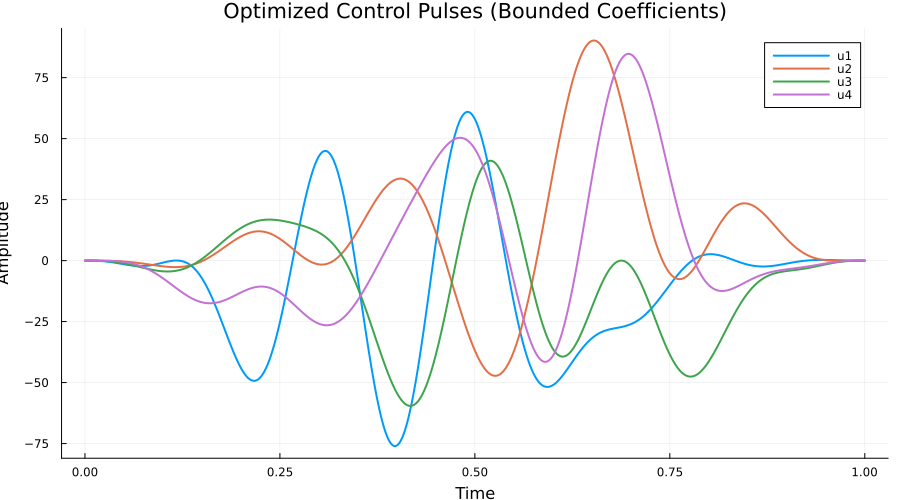

Final propagator matrix:
ComplexF64[-0.2096197285750918 - 0.08104859150393565im 0.0184246288532045 + 0.033893045111163936im -0.1419488265392128 + 0.9478894032212368im -0.07724390881935982 - 0.10524589707049832im 0.01546547184142489 + 0.017502704596941417im -0.03808223391970441 + 0.03272551656391355im -0.024292518708903855 + 0.07063620256673257im 0.056467068492316246 + 0.022825278990512003im; -0.12619828526213997 - 0.013065760711561025im 0.04996853405418214 + 0.5686544401453645im 0.060715553240230744 - 0.11126814151707315im -0.28837597608284776 - 0.6785249325262339im -0.05872628631970397 + 0.0005263912150113569im 0.07817197340829045 - 0.20138809225517587im -0.0283447431963044 - 0.1734946704133919im -0.11756357276572918 + 0.05951621563308787im; -0.8590275738149163 + 0.32164298338599223im -0.1286509627858871 - 0.15543505287242212im -0.08487812141939206 - 0.16167822284498878im 0.11293015792153617 + 0.019143085494184264im 0.028388357738990982 + 0.03814133671544365im -0.12828018769195504 - 0

In [2]:
using LinearAlgebra
using Random
using Optim
using Plots
using Printf

function zL_minus_cavity(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-3, 4)
        k = 4n + 2
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

function zL_cavitypos(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-1, 4)
        k = 4n
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

α = sqrt(3)
ψ_cavidealminus = zL_minus_cavity(α; d_c = 4)
ψ_cavidealpos   = zL_cavitypos(α; d_c = 4)

# Ground state |0>
ground_state = zeros(ComplexF64, 4)
excited_state = zeros(ComplexF64, 4)
ground_state[1] = 1.0 + 0im
excited_state[2] = 1.0 + 0im

# Avoid aliasing: make copies if you'll mutate these later
ψ_trainitialg = copy(ground_state[1:2]);
ψ_trainitiale = copy(excited_state[1:2]);

ψ_cavinitial = copy(ground_state);

ψ_inig = kron(ψ_trainitialg, ψ_cavinitial);
ψ_inie = kron(ψ_trainitiale, ψ_cavinitial);
ψ_Zgminus = kron(ψ_trainitialg, ψ_cavidealminus);
ψ_Zgpos = kron(ψ_trainitialg, ψ_cavidealpos);
ψ_Zeminus = kron(ψ_trainitiale, ψ_cavidealminus);
ψ_Zepos = kron(ψ_trainitiale, ψ_cavidealpos);

function make_system(; d_q=2, d_c=4)
    Iq = Matrix{ComplexF64}(I, d_q, d_q)
    
    a = zeros(ComplexF64, d_c, d_c)
    for n in 2:d_c
        a[n-1, n] = sqrt(n-1)
    end
    b = zeros(ComplexF64, d_q, d_q)
    for n in 2:d_q
        b[n-1, n] = sqrt(n-1)
    end
    a⁺ = a'
    b⁺ = b'
    Ic = Matrix{ComplexF64}(I, d_c, d_c)

    ω_T  = 5664.0 * 2 * pi # no use here
    ω_C  = 4452.6 * 2 * pi # no use here
    χ   = -2.194 * 2 * pi
    α   = -236.0 * 2 * pi
    k   = -0.0037 * 2 * pi
    χ′  = -0.019 * 2 * pi
    
    H_oscillator =  (k/(2)) * (kron(Iq, a⁺) * kron(Iq, a⁺) * kron(Iq, a) * kron(Iq, a))
    H_transmon = (α/(2)) * (kron(b⁺, Ic) * kron(b⁺, Ic) * kron(b, Ic) * kron(b, Ic))
    H_interaction = (χ) * (kron(Iq, a⁺) * kron(Iq, a) * kron(b⁺, Ic) * kron(b, Ic)) +
    (χ′/(2)) * kron(b⁺, Ic) * kron(b, Ic) * kron(Iq, a⁺) * kron(Iq, a⁺) * kron(Iq, a) * kron(Iq, a)

    H0 = H_oscillator + H_transmon + H_interaction
    
    Hx = kron(b + b⁺, Ic)
    Hy = kron(1im*(b⁺- b), Ic)
    HcX = kron(Iq, a + a⁺)
    HcY = kron(Iq, 1im*(a⁺ - a))
    
    return H0, [Hx, Hy, HcX, HcY], (d_q, d_c)
end

function fidelity_and_phase(U)
    d = size(U, 1)
    J = abs((ψ_Zgpos' * U * ψ_Zgminus))^2 +
        abs((ψ_Zgminus' * U * ψ_Zgpos))^2 +
        abs((ψ_Zepos' * U * ψ_Zeminus))^2 +
        abs((ψ_Zeminus' * U * ψ_Zepos))^2
    F = J / 4
    return F, J
end

function fourier_sine_bank(N, K)
    t = collect(0:N-1)
    M = zeros(Float64, K, N)
    for r in 1:K
        M[r, :] = sin.(π * r * t / N)
    end
    return M
end

function raised_cosine(N)
    return 0.5 * (1.0 .- cos.(2 * π * collect(0:N-1) / N))
end

function coeffs_to_pulses(theta, N, K; m=4)
    @assert length(theta) == m*(K+1)
    rc = raised_cosine(N)
    S = K > 0 ? fourier_sine_bank(N, K) : zeros(Float64, 0, N)
    u_list = Vector{Vector{Float64}}()
    ofs = 1
    for _j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        u = b0 .+ (K > 0 ? (br' * S)[:] : zeros(Float64, N))
        push!(u_list, (u .* rc))
        ofs += (K+1)
    end
    return u_list
end

function propagate_from_pulses(H0, H_controls, u_list, T)
    N = length(u_list[1])
    dt = T / N
    d = size(H0, 1)
    U = Matrix{ComplexF64}(I, d, d)
    m = length(H_controls)
    
    function H_t(k)
        H = copy(H0)
        for j in 1:m
            H += u_list[j][k] * H_controls[j]
        end
        return H
    end
    
    for k in 1:N
        Hk = H_t(k)
        K1 = -1im * Hk * U
        Hk_next = H_t(min(k+1, N))
        K2 = -1im * Hk_next * (U + 0.5 * dt * K1)
        K3 = -1im * Hk_next * (U + 0.5 * dt * K2)
        K4 = -1im * Hk_next * (U + dt * K3)
        U = U + (dt / 6.0) * (K1 + 2*K2 + 2*K3 + K4)
    end
    return U
end

function nm_cost(theta, H0, H_controls, T, N, K; amp_clip=nothing)
    u_list = coeffs_to_pulses(theta, N, K, m=length(H_controls))
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, _ = fidelity_and_phase(U)
    return 1.0 - F
end

function run_nelder_mead(T, N, phi; K=12, seed=42, init_scale= 1.0 * (2 * pi * 5),
                        amp_clip=nothing, maxiter=5000, f_abstol=1e-5, x_abstol=1e-5)
    H0, H_controls, _ = make_system()
    m = length(H_controls)
    
    Random.seed!(seed)
    
    theta0 = Float64[]
    for _ in 1:m
        push!(theta0, 0.0)
        append!(theta0, init_scale * (2*rand(K) .- 1))
    end

    function objective(th)
        th_clipped = clamp.(th, -init_scale, init_scale)
        return nm_cost(th_clipped, H0, H_controls, T, N, K, amp_clip=amp_clip)
    end

    res = optimize(objective, theta0, NelderMead(),
                Optim.Options(iterations=maxiter, f_abstol=f_abstol, x_abstol=x_abstol))
    
    theta = clamp.(Optim.minimizer(res), -init_scale, init_scale)
    
    u_list = coeffs_to_pulses(theta, N, K, m=m)
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, J = fidelity_and_phase(U)

    return Dict("theta" => theta, "u_list" => u_list, "U_final" => U,
            "F" => F, "J" => J, "res" => res)
end

function plot_pulses(u_list, T; title="Four-channel pulses (Nelder–Mead)")
    N = length(u_list[1])
    t = range(0.0, T, length=N)
    
    gr()
    
    p = plot(size=(900, 500), title=title)
    
    for (idx, u) in enumerate(u_list)
        plot!(p, t, u, label="u$(idx)", linewidth=2)
    end
    
    xlabel!(p, "Time")
    ylabel!(p, "Amplitude")
    plot!(p, grid=true, legend=:best)
    
    display(p)
    savefig(p, "quantum_pulses.png")
    
    return p
end

function generate_pulses()
    T = 1  
    phi = π
    N = 1000
    K = 12
    
    result = run_nelder_mead(T, N, phi, K=K, seed=42, init_scale= 1.0 * (2 * pi * 5), maxiter=5000, f_abstol=1e-5, x_abstol=1e-5)
    
    println("Final Fidelity: $(result["F"])")
    
    plot_pulses(result["u_list"], T, title="Optimized Control Pulses (Bounded Coefficients)")
    
    return result
end

result = generate_pulses()
H0, H_controls, _ = make_system()
final_propagator = propagate_from_pulses(H0, H_controls, result["u_list"], 1)
println("Final propagator matrix:")
println(final_propagator)

LFBGS

Iter     Function value   Gradient norm 
     0     9.339738e-01     6.767113e-02
 * time: 0.012327909469604492
     1     7.662812e-01     2.602439e-02
 * time: 2.529256820678711
     2     6.798362e-01     6.312961e-02
 * time: 4.094841003417969
     3     5.884599e-01     2.999961e-02
 * time: 4.9650609493255615
     4     5.556498e-01     2.501128e-02
 * time: 6.344391822814941
     5     5.263871e-01     1.483553e-02
 * time: 7.667206048965454
     6     4.847925e-01     1.641037e-02
 * time: 9.141778945922852
     7     3.903538e-01     2.478723e-02
 * time: 10.557718992233276
     8     3.445524e-01     3.228943e-02
 * time: 11.518456935882568
     9     2.589757e-01     2.090955e-02
 * time: 12.943224906921387
    10     2.176564e-01     1.394470e-02
 * time: 13.96402382850647
    11     1.927198e-01     1.450862e-02
 * time: 15.431228876113892
    12     1.663983e-01     1.356322e-02
 * time: 16.96500301361084
    13     1.573078e-01     1.086338e-02
 * time: 17.85393786430359

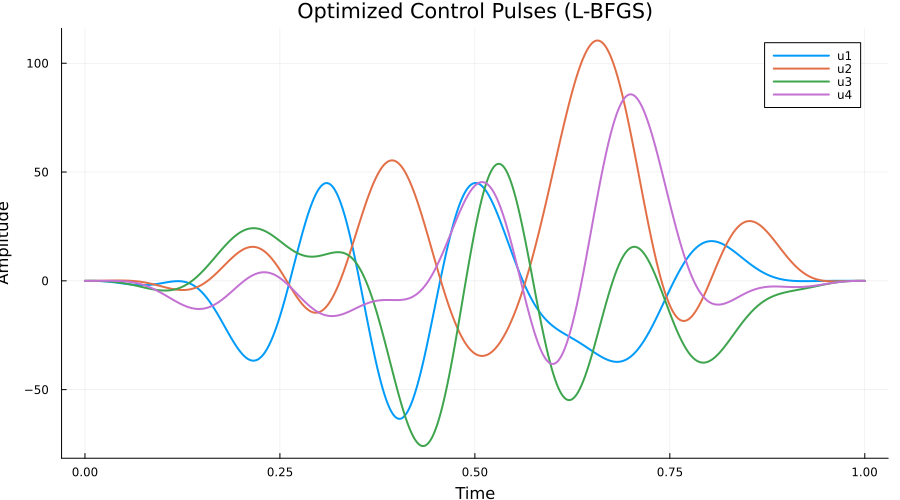

Final propagator matrix:
ComplexF64[0.07844675746541126 + 0.04016507082049532im 0.09722364931791876 - 0.11400911669579351im 0.974466661193432 - 0.03111072942431293im 0.05587362040448366 + 0.03862675895257177im 0.024323632300294305 - 0.0418825049671226im -0.05128796083103706 - 0.009557372870040794im 0.0004342346730370495 - 0.010434087651857672im -0.07843154584345813 - 0.057743100685204315im; -0.14170115924629956 + 0.05637626305296319im -0.25084906720339134 + 0.4763961435265181im 0.15545779460959264 - 0.025245207960029187im -0.5391562590241297 - 0.48387994236868176im -0.12558811327407696 + 0.07799128934461821im 0.002304225054381576 - 0.2736322700674674im -0.020803236511300022 - 0.08090717355124342im 0.031601779824646056 + 0.18025582778251956im; 0.9238071932133279 + 0.006932453037435724im 0.07626326706696657 - 0.007281846213047833im -0.0635438846569125 + 0.06725223128514575im -0.036213699435129504 - 0.20151767420001943im -0.032138330105990556 - 0.04730769906997687im -0.0768831593943904 + 

In [3]:
using LinearAlgebra
using Random
using Optim
using Plots
using Printf

function zL_minus_cavity(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-3, 4)
        k = 4n + 2
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

function zL_cavitypos(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-1, 4)
        k = 4n
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

α = sqrt(3)
ψ_cavidealminus = zL_minus_cavity(α; d_c = 4)
ψ_cavidealpos   = zL_cavitypos(α; d_c = 4)

# Ground state |0>
ground_state = zeros(ComplexF64, 4)
excited_state = zeros(ComplexF64, 4)
ground_state[1] = 1.0 + 0im
excited_state[2] = 1.0 + 0im

# Avoid aliasing: make copies if you'll mutate these later
ψ_trainitialg = copy(ground_state[1:2]);
ψ_trainitiale = copy(excited_state[1:2]);

ψ_cavinitial = copy(ground_state);

ψ_inig = kron(ψ_trainitialg, ψ_cavinitial);
ψ_inie = kron(ψ_trainitiale, ψ_cavinitial);
ψ_Zgminus = kron(ψ_trainitialg, ψ_cavidealminus);
ψ_Zgpos = kron(ψ_trainitialg, ψ_cavidealpos);
ψ_Zeminus = kron(ψ_trainitiale, ψ_cavidealminus);
ψ_Zepos = kron(ψ_trainitiale, ψ_cavidealpos);

function make_system(; d_q=2, d_c=4)
    Iq = Matrix{ComplexF64}(I, d_q, d_q)
    
    a = zeros(ComplexF64, d_c, d_c)
    for n in 2:d_c
        a[n-1, n] = sqrt(n-1)
    end
    b = zeros(ComplexF64, d_q, d_q)
    for n in 2:d_q
        b[n-1, n] = sqrt(n-1)
    end
    a⁺ = a'
    b⁺ = b'
    Ic = Matrix{ComplexF64}(I, d_c, d_c)

    ω_T  = 5664.0 * 2 * pi
    ω_C  = 4452.6 * 2 * pi
    χ   = -2.194 * 2 * pi
    α   = -236.0 * 2 * pi
    k   = -0.0037 * 2 * pi
    χ′  = -0.019 * 2 * pi
    
    H_oscillator =  (k/(2)) * (kron(Iq, a⁺) * kron(Iq, a⁺) * kron(Iq, a) * kron(Iq, a))
    H_transmon = (α/(2)) * (kron(b⁺, Ic) * kron(b⁺, Ic) * kron(b, Ic) * kron(b, Ic))
    H_interaction = (χ) * (kron(Iq, a⁺) * kron(Iq, a) * kron(b⁺, Ic) * kron(b, Ic)) +
    (χ′/(2)) * kron(b⁺, Ic) * kron(b, Ic) * kron(Iq, a⁺) * kron(Iq, a⁺) * kron(Iq, a) * kron(Iq, a)

    H0 = H_oscillator + H_transmon + H_interaction
    
    Hx = kron(b + b⁺, Ic)
    Hy = kron(1im*(b⁺- b), Ic)
    HcX = kron(Iq, a + a⁺)
    HcY = kron(Iq, 1im*(a⁺ - a))
    
    return H0, [Hx, Hy, HcX, HcY], (d_q, d_c)
end

function fidelity_and_phase(U)
    d = size(U, 1)
    J = (ψ_Zgpos)'* U * ψ_Zgminus + (ψ_Zgminus)'* U * ψ_Zgpos + (ψ_Zepos)' * U * ψ_Zeminus + (ψ_Zeminus)'* U * ψ_Zepos
    # Take the real part since J should be real for a proper fidelity measure
    J_real = real(J)
    F = J_real/4
    return F, J_real
end

function fourier_sine_bank(N, K)
    t = collect(0:N-1)
    M = zeros(Float64, K, N)
    for r in 1:K
        M[r, :] = sin.(π * r * t / N)
    end
    return M
end

function raised_cosine(N)
    return 0.5 * (1.0 .- cos.(2 * π * collect(0:N-1) / N))
end

function coeffs_to_pulses(theta, N, K; m=4)
    @assert length(theta) == m*(K+1)
    rc = raised_cosine(N)
    S = K > 0 ? fourier_sine_bank(N, K) : zeros(Float64, 0, N)
    u_list = Vector{Vector{Float64}}()
    ofs = 1
    for _j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        u = b0 .+ (K > 0 ? (br' * S)[:] : zeros(Float64, N))
        push!(u_list, (u .* rc))
        ofs += (K+1)
    end
    return u_list
end

function propagate_from_pulses(H0, H_controls, u_list, T)
    N = length(u_list[1])
    dt = T / N
    d = size(H0, 1)
    U = Matrix{ComplexF64}(I, d, d)
    m = length(H_controls)
    
    function H_t(k)
        H = copy(H0)
        for j in 1:m
            H += u_list[j][k] * H_controls[j]
        end
        return H
    end
    
    for k in 1:N
        Hk = H_t(k)
        K1 = -1im * Hk * U
        Hk_next = H_t(min(k+1, N))
        K2 = -1im * Hk_next * (U + 0.5 * dt * K1)
        K3 = -1im * Hk_next * (U + 0.5 * dt * K2)
        K4 = -1im * Hk_next * (U + dt * K3)
        U = U + (dt / 6.0) * (K1 + 2*K2 + 2*K3 + K4)
    end
    return U
end

function nm_cost(theta, H0, H_controls, T, N, K; amp_clip=nothing)
    u_list = coeffs_to_pulses(theta, N, K, m=length(H_controls))
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, _ = fidelity_and_phase(U)
    return 1.0 - F
end

function run_lbfgs(T, N, phi; K=12, seed=42, init_scale=1.0 * (2 * pi * 5),
                amp_clip=nothing, maxiter=80, f_abstol=1e-6, x_abstol=1e-6)
    H0, H_controls, _ = make_system()
    m = length(H_controls)
    
    Random.seed!(seed)
    
    theta0 = Float64[]
    for _ in 1:m
        push!(theta0, 0.0)
        append!(theta0, init_scale * (2*rand(K) .- 1))
    end

    function objective(th)
        th_clipped = clamp.(th, -init_scale, init_scale)
        return nm_cost(th_clipped, H0, H_controls, T, N, K, amp_clip=amp_clip)
    end

    res = optimize(objective, theta0, Optim.LBFGS(),
                Optim.Options(iterations=maxiter, f_abstol=f_abstol, x_abstol=x_abstol, show_trace=true))
    
    theta = clamp.(Optim.minimizer(res), -init_scale, init_scale)
    
    u_list = coeffs_to_pulses(theta, N, K, m=m)
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, J = fidelity_and_phase(U)

    return Dict("theta" => theta, "u_list" => u_list, "U_final" => U,
            "F" => F, "J" => J, "res" => res)
end

function plot_pulses(u_list, T; title="Four-channel pulses (L-BFGS)")
    N = length(u_list[1])
    t = range(0.0, T, length=N)
    
    gr()
    
    p = plot(size=(900, 500), title=title)
    
    for (idx, u) in enumerate(u_list)
        plot!(p, t, u, label="u$(idx)", linewidth=2)
    end
    
    xlabel!(p, "Time")
    ylabel!(p, "Amplitude")
    plot!(p, grid=true, legend=:best)
    
    display(p)
    savefig(p, "quantum_pulses.png")
    
    return p
end

function generate_pulses()
    T = 1  
    phi = π
    N = 1000
    K = 12
    
    result = run_lbfgs(T, N, phi, K=K, seed=42, init_scale=1.0 * (2 * pi * 5), maxiter=80, f_abstol=1e-6, x_abstol=1e-6)
    
    println("Final Fidelity: $(result["F"])")
    
    plot_pulses(result["u_list"], T, title="Optimized Control Pulses (L-BFGS)")
    
    return result
end

result = generate_pulses()
H0, H_controls, _ = make_system()
final_propagator = propagate_from_pulses(H0, H_controls, result["u_list"], 1)
println("Final propagator matrix:")
println(final_propagator)

In [4]:
using Printf
println("Final propagator matrix:")
for i in 1:size(result["U_final"], 1)
    for j in 1:size(result["U_final"], 2)
        @printf("%8.4f%+8.4fi  ", real(result["U_final"][i,j]), imag(result["U_final"][i,j]))
    end
    println()
end

Final propagator matrix:
  0.0784 +0.0402i    0.0972 -0.1140i    0.9745 -0.0311i    0.0559 +0.0386i    0.0243 -0.0419i   -0.0513 -0.0096i    0.0004 -0.0104i   -0.0784 -0.0577i  
 -0.1417 +0.0564i   -0.2508 +0.4764i    0.1555 -0.0252i   -0.5392 -0.4839i   -0.1256 +0.0780i    0.0023 -0.2736i   -0.0208 -0.0809i    0.0316 +0.1803i  
  0.9238 +0.0069i    0.0763 -0.0073i   -0.0635 +0.0673i   -0.0362 -0.2015i   -0.0321 -0.0473i   -0.0769 +0.0078i   -0.1418 -0.0440i   -0.0170 +0.2421i  
 -0.2184 +0.0456i    0.4195 +0.1133i    0.0398 +0.0219i    0.0903 -0.1729i   -0.1723 -0.1458i    0.1140 +0.4954i    0.0896 +0.1183i    0.0407 +0.6230i  
  0.1497 -0.0639i    0.0300 +0.0588i   -0.0174 -0.0108i   -0.0550 +0.0029i    0.0072 +0.0284i   -0.1057 -0.0345i    0.9713 +0.0131i   -0.0832 -0.0449i  
 -0.0569 +0.1418i   -0.1325 -0.2433i   -0.0126 +0.0393i   -0.1052 -0.3104i   -0.1595 +0.0813i   -0.6438 +0.4574i   -0.0120 -0.0024i    0.2647 -0.2544i  
 -0.0465 -0.0001i    0.0653 -0.0450i   -0.0012 -0.0313i  